# Evaluación de PC-SMOTE con Grid Search en el dataset Shuttle (Generación de caso base y datasets aumentados)


In [1]:
# lo que hace es modificar la lista de rutas de búsqueda de módulos de Python (sys.path) para incluir las carpetas ../scripts y ../datasets como ubicaciones adicionales donde Python puede buscar módulos o paquetes cuando hacés un import.
import sys
sys.path.append("../scripts")
sys.path.append("../datasets")

## Importación de módulos y librerías necesarias


In [ ]:
# --- Módulos propios del proyecto ---
from cargar_dataset import cargar_dataset                      # Función para cargar datasets según configuración
from config_datasets import config_datasets                    # Diccionario de configuración de datasets
from evaluacion import evaluar_sampler_holdout                 # Evaluación de sobremuestreo con partición hold-out
from custom_samplers import PCSMOTEWrapper                     # Wrapper personalizado para la técnica PCSMOTE
from pc_smote import PCSMOTE                                   # Implementación principal de PCSMOTE
# --- Librerías estándar de Python ---
from datetime import datetime, timedelta                       # Manejo de fechas y tiempos
from itertools import product                                  # Generación de combinaciones de parámetros
import gc, os, time                                                      # Operaciones con el sistema de archivos

from sklearn.experimental import enable_halving_search_cv  # noqa: F401  <- necesario
from sklearn.model_selection import HalvingRandomSearchCV

# --- Librerías científicas ---
import numpy as np                                              # Operaciones numéricas y algebra lineal
import pandas as pd                                             # Manipulación y análisis de datos tabulares
from scipy.stats import uniform                                 # Distribuciones para búsqueda de hiperparámetros

# --- Scikit-learn: preprocesamiento ---
from sklearn.preprocessing import LabelEncoder, StandardScaler # Codificación de etiquetas y escalado de datos
from sklearn.pipeline import make_pipeline, Pipeline            # Creación de pipelines de procesamiento y modelado

# --- Scikit-learn: división y validación ---
from sklearn.model_selection import (
    train_test_split,                                           # División de datos en train/test
    StratifiedKFold,                                            # Validación cruzada estratificada
    RandomizedSearchCV                                          # Búsqueda aleatoria de hiperparámetros
)

# --- Scikit-learn: reducción de dimensionalidad ---
from sklearn.decomposition import PCA                           # Análisis de Componentes Principales

# --- Scikit-learn: métricas ---
from sklearn.metrics import (
    f1_score,                                                    # Métrica F1-Score
    balanced_accuracy_score,                                     # Precisión balanceada
    matthews_corrcoef,                                           # Coeficiente MCC
    cohen_kappa_score,                                           # Kappa de Cohen
    make_scorer                                            
)

# --- Scikit-learn: clasificadores ---
from sklearn.ensemble import RandomForestClassifier             # Clasificador Random Forest
from sklearn.linear_model import LogisticRegression             # Regresión logística
from sklearn.svm import SVC                                      # Máquinas de Vectores de Soporte (SVM)
from scipy.stats import loguniform, randint, uniform

from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Evitar sobre-suscripción de CPU (BLAS/OpenMP)
os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")
os.environ.setdefault("NUMEXPR_NUM_THREADS", "1")
SCORING_PRIMARY = 'f1_macro'  # único métrico para Halving

### Evaluación de modelos con validación cruzada estratificada

Para evaluar el rendimiento de los modelos de clasificación sobre los datasets previamente balanceados, se utilizó validación cruzada estratificada de 5 particiones (Stratified K-Fold con *k=5*). Este método garantiza que en cada fold de entrenamiento y validación se preserve la proporción original de clases, lo cual es especialmente importante en tareas de clasificación multiclase con datasets balanceados artificialmente.

Durante el proceso, cada modelo es entrenado y evaluado cinco veces, cada vez usando un subconjunto distinto como conjunto de prueba y el resto como conjunto de entrenamiento. Las métricas calculadas en cada iteración (F1-score macro, balanced accuracy, MCC y kappa de Cohen) se promedian para obtener un valor representativo y del rendimiento general del modelo sobre ese dataset aumentado.

Este enfoque evita sobreajuste y proporciona una evaluación más confiable que una simple división train/test, permitiendo comparar de forma justa distintas configuraciones de sobremuestreo y modelos de clasificación.


In [ ]:
import os, gc, time
from dataclasses import dataclass, asdict
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import (
    f1_score, balanced_accuracy_score, matthews_corrcoef, cohen_kappa_score,
    make_scorer
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from scipy.stats import randint, uniform, loguniform

# =========================
# Configuración general
# =========================
RUTA_DATASETS_BASE = "../datasets/datasets_aumentados/base/"
RUTA_DATASETS_AUMENTADOS = "../datasets/datasets_aumentados/"
DIRECTORIO_SALIDA = "../resultados"
os.makedirs(DIRECTORIO_SALIDA, exist_ok=True)

RANDOM_STATE = 42
SCORING_REFIT = "f1_macro"
SCORING_MULTIPLE = {
    "f1_macro": "f1_macro",
    "balanced_accuracy": "balanced_accuracy",
    "mcc": make_scorer(matthews_corrcoef),
    "cohen_kappa": make_scorer(cohen_kappa_score),
}
N_ITER_BUSQUEDA_POR_DEFECTO = 40
OMITIR_SVM_EN_SHUTTLE_AUMENTADO = True  # política opcional
NOMBRE_ARCHIVO_EXCEL = os.path.join(DIRECTORIO_SALIDA, "resultados_RS_cv_vs_test.xlsx")

# =========================
# Estructuras de datos
# =========================
@dataclass
class DatasetCombination:
    """Representa una combinación base o aumentada (metadatos y paths)."""
    dataset_logico: str          # p. ej. "Shuttle"
    tipo_combination: str        # "base" | "aumentado"
    ruta_train_csv: str
    ruta_test_csv: str
    tecnica_aumento: str = "base"
    valor_densidad: str = "--"
    valor_riesgo: str = "--"
    criterio_pureza: str = "--"

@dataclass
class RegistroRendimiento:
    """Fila de resultados con métricas CV vs Test y auditoría de búsqueda."""
    dataset_logico: str
    tipo_combination: str
    nombre_modelo_aprendizaje: str
    tecnica_aumento: str
    valor_densidad: str
    valor_riesgo: str
    criterio_pureza: str
    cantidad_train: int
    cantidad_test: int
    cantidad_caracteristicas: int
    # CV (sobre el mejor candidato de RS)
    cv_f1_macro: float
    cv_balanced_accuracy: float
    cv_mcc: float
    cv_cohen_kappa: float
    # Test
    test_f1_macro: float
    test_balanced_accuracy: float
    test_mcc: float
    test_cohen_kappa: float
    # Auditoría
    mejores_hiperparametros: str
    tiempo_busqueda_seg: float

# =========================
# Utilidades de datos
# =========================
def cargar_matriz_caracteristicas_y_etiquetas_desde_csv(ruta_csv):
    """Lee un CSV y devuelve (X, y). Si existe 'target', la usa; si no, usa la última columna como y."""
    df = pd.read_csv(ruta_csv)
    if "target" in df.columns:
        X = df.drop(columns=["target"]).to_numpy(dtype=np.float32, copy=False)
        y = df["target"].to_numpy()
    else:
        X = df.iloc[:, :-1].to_numpy(dtype=np.float32, copy=False)
        y = df.iloc[:, -1].to_numpy()
    return X, y

def enumerar_combinaciones_base_y_aumentadas(ruta_base, ruta_aumentados, verbose=True):
    """
    Descubre *_train.csv y su *_test.csv correspondiente.
    Base: usa nombre lógico tal cual.
    Aumentados: espera tecnica_dataset_Dx_Ry_Pz_train.csv para extraer metadatos.
    Si verbose=True, imprime diagnósticos de archivos encontrados/omitidos.
    """
    combinaciones = []

    # ===================== BASES =====================
    if os.path.isdir(ruta_base):
        if verbose:
            print(f"📂 Explorando carpeta base: {ruta_base}")
        for nombre in sorted(os.listdir(ruta_base)):
            if not nombre.endswith("_train.csv"):
                if verbose:
                    print(f"  ⚪ Omitido (no es *_train.csv): {nombre}")
                continue

            ruta_train = os.path.join(ruta_base, nombre)
            ruta_test = os.path.join(ruta_base, nombre.replace("_train.csv", "_test.csv"))

            if not os.path.isfile(ruta_test):
                if verbose:
                    print(f"  ⚠️  Falta test para {nombre}, se omite.")
                continue

            dataset_logico = nombre.replace("_train.csv", "")
            combinaciones.append(DatasetCombination(
                dataset_logico=dataset_logico,
                tipo_combination="base",
                ruta_train_csv=ruta_train,
                ruta_test_csv=ruta_test
            ))
            if verbose:
                print(f"  ✅ Base encontrada: {dataset_logico}")
    else:
        if verbose:
            print(f"❌ No existe carpeta base: {ruta_base}")

    # ===================== AUMENTADOS =====================
    if os.path.isdir(ruta_aumentados):
        if verbose:
            print(f"📂 Explorando carpeta aumentados: {ruta_aumentados}")
        for nombre in sorted(os.listdir(ruta_aumentados)):
            if not nombre.endswith("_train.csv"):
                if verbose:
                    print(f"  ⚪ Omitido (no es *_train.csv): {nombre}")
                continue

            ruta_train = os.path.join(ruta_aumentados, nombre)
            ruta_test = os.path.join(ruta_aumentados, nombre.replace("_train.csv", "_test.csv"))

            if not os.path.isfile(ruta_test):
                if verbose:
                    print(f"  ⚠️  Falta test para {nombre}, se omite.")
                continue

            partes = nombre.replace("_train.csv", "").split("_")
            if len(partes) >= 5:
                tecnica, dataset_logico, dens, ries, pur = partes[:5]
                combinaciones.append(DatasetCombination(
                    dataset_logico=dataset_logico,
                    tipo_combination="aumentado",
                    ruta_train_csv=ruta_train,
                    ruta_test_csv=ruta_test,
                    tecnica_aumento=tecnica,
                    valor_densidad=dens[1:],   # quita 'D'
                    valor_riesgo=ries[1:],     # quita 'R'
                    criterio_pureza=pur[1:]    # quita 'P'
                ))
                if verbose:
                    print(f"  ✅ Aumentado encontrado: {nombre}")
            else:
                if verbose:
                    print(f"  ⚠️  No cumple patrón esperado (tecnica_dataset_Dx_Ry_Pz): {nombre}")
    else:
        if verbose:
            print(f"❌ No existe carpeta aumentados: {ruta_aumentados}")

    if verbose:
        print(f"📊 Total combinaciones descubiertas: {len(combinaciones)}")
    return combinaciones

def definir_configuracion_busqueda_para_dataset(X_train, nombre_dataset_logico, tipo_combination):
    """
    Define la configuración de búsqueda: esquema de CV (n_splits), n_iter (RandomizedSearchCV) y n_jobs.
    Mantiene: Shuttle aumentado → 2 folds; Shuttle o n≥10k → 3 folds; resto → 5 folds.
    """
    n_muestras = X_train.shape[0]
    es_shuttle = (nombre_dataset_logico.lower() == "shuttle")
    if es_shuttle and tipo_combination == "aumentado":
        cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=RANDOM_STATE)
    elif es_shuttle or n_muestras >= 10000:
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
    else:
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

    cpu = os.cpu_count() or 4
    n_jobs = 1 if (es_shuttle or n_muestras >= 10000) else max(1, min(4, cpu // 2))
    n_iter = 25 if (es_shuttle or n_muestras >= 10000) else N_ITER_BUSQUEDA_POR_DEFECTO
    return dict(cv=cv, n_jobs=n_jobs, n_iter=n_iter)

# =========================
# Registro de modelos
# =========================
def construir_estimador_y_espacio_svm():
    """Devuelve (pipeline SVM, espacio de hiperparámetros) con kernels linear/rbf."""
    est = Pipeline([('classifier', SVC(random_state=RANDOM_STATE, probability=False, max_iter=5000, cache_size=400))])
    # espacio de busqueda de hiperparametros,
    # combinaciones posibles para cada
    # hiperparametro del modelo
    space = {
        'classifier__kernel': ['linear', 'rbf'],
        'classifier__C': loguniform(1e-3, 1e2),
        'classifier__gamma': loguniform(1e-4, 1e0),  # ignorado cuando kernel='linear'
        'classifier__shrinking': [True, False],
        'classifier__class_weight': [None, 'balanced'],
    }
    return est, space

def construir_estimador_y_espacio_regresion_logistica_saga():
    """Devuelve (pipeline LR con solver saga) evitando combinaciones inválidas; penalización L1/L2."""
    est = Pipeline([('classifier', LogisticRegression(max_iter=5000, random_state=RANDOM_STATE, solver='saga'))])
    # espacio de busqueda de hiperparametros,
    # combinaciones posibles para cada
    # hiperparametro del modelo
    space = {
        'classifier__penalty': ['l1', 'l2'],
        'classifier__C': loguniform(1e-4, 1e2),
        'classifier__fit_intercept': [True, False],
        'classifier__class_weight': [None, 'balanced'],
        'classifier__tol': loguniform(1e-5, 1e-3),
        'classifier__l1_ratio': [None],  # evitamos elasticnet para simplificar
    }
    return est, space

def construir_estimador_y_espacio_random_forest():
    """Devuelve (pipeline RF) con espacio adecuado para RS; el RF interno usa n_jobs=1 para no sobreparalelizar."""
    est = Pipeline([('classifier', RandomForestClassifier(
        random_state=RANDOM_STATE, n_jobs=1, bootstrap=True, oob_score=False
    ))])
    # espacio de busqueda de hiperparametros,
    # combinaciones posibles para cada
    # hiperparametro del modelo
    space = {
        'classifier__n_estimators': randint(150, 500),
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__max_depth': [None, 10, 20, 40],
        'classifier__min_samples_split': randint(2, 21),
        'classifier__min_samples_leaf': randint(1, 11),
        'classifier__max_features': ['sqrt', 'log2'],
        'classifier__class_weight': [None, 'balanced', 'balanced_subsample'],
        'classifier__ccp_alpha': uniform(0.0, 0.01),
        'classifier__max_samples': uniform(0.6, 0.35)  # 0.6–0.95 acelera en grandes
    }
    return est, space

REGISTRO_MODELOS = {
    "LogisticRegression": construir_estimador_y_espacio_regresion_logistica_saga,
    "RandomForest": construir_estimador_y_espacio_random_forest,
    "SVM": construir_estimador_y_espacio_svm
}
ORDEN_MODELOS = ["LogisticRegression", "RandomForest", "SVM"]  # rápido → lento

# =========================
# Entrenamiento y evaluación
# =========================
def ejecutar_rs_y_comparar_cv_con_test(estimator, space, X_train, y_train, X_test, y_test, configuracion_busqueda, verbose=0):
    """
    Ejecuta RandomizedSearchCV con scoring múltiple (refit=f1_macro).
    Devuelve métricas promedio de CV del mejor candidato y métricas en Test, más auditoría.
    """
    search = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=space,
        n_iter=configuracion_busqueda["n_iter"],
        scoring=SCORING_MULTIPLE,
        refit=SCORING_REFIT,    # métrico principal para elegir el mejor 
        cv=configuracion_busqueda["cv"], 
        random_state=RANDOM_STATE,
        n_jobs=configuracion_busqueda["n_jobs"],
        verbose=verbose,
        error_score=np.nan,
        return_train_score=False
    )
    t0 = time.perf_counter()
    search.fit(X_train, y_train)
    elapsed = round(time.perf_counter() - t0, 3)

    # Métricas de CV del mejor índice
    best_idx = search.best_index_
    cv_results = search.cv_results_
    cv_f1 = float(cv_results['mean_test_f1_macro'][best_idx])
    cv_bacc = float(cv_results['mean_test_balanced_accuracy'][best_idx])
    cv_mcc = float(cv_results['mean_test_mcc'][best_idx])
    cv_kappa = float(cv_results['mean_test_cohen_kappa'][best_idx])

    # Métricas Test
    best_estimator = search.best_estimator_
    y_pred_test = best_estimator.predict(X_test)
    test_f1 = float(f1_score(y_test, y_pred_test, average='macro'))
    test_bacc = float(balanced_accuracy_score(y_test, y_pred_test))
    test_mcc = float(matthews_corrcoef(y_test, y_pred_test))
    test_kappa = float(cohen_kappa_score(y_test, y_pred_test))

    return dict(
        mejores_params=search.best_params_,
        tiempo=elapsed,
        cv=dict(f1=cv_f1, bacc=cv_bacc, mcc=cv_mcc, kappa=cv_kappa),
        test=dict(f1=test_f1, bacc=test_bacc, mcc=test_mcc, kappa=test_kappa)
    )

# =========================
# Orquestación (lista plana de tareas)
# --- Políticas globales de exclusión (en minúsculas) ---
EXCLUIR_DATASETS = {"shuttle"}  # agregar aquí otros: {"shuttle", "ecoli", ...}
# =========================

def construir_lista_plana_de_tareas(model_registry, dataset_combinations, orden_modelos,
                                    excluir_datasets=EXCLUIR_DATASETS, verbose=True):
    """
    Crea una lista plana de tareas (modelo, combinación) y aplica políticas de exclusión.
    - excluir_datasets: conjunto de nombres de dataset (en minúsculas) a excluir por completo.
    - Mantiene la política existente de omitir SVM en Shuttle aumentado si está activa.
    """
    tareas = []
    excluidos_por_dataset = 0
    excluidos_por_politica_svm_shuttle = 0

    for nombre_modelo in orden_modelos:
        for combo in dataset_combinations:
            ds = combo.dataset_logico.lower()

            # 1) Excluir datasets completos (p. ej., shuttle)
            if ds in (excluir_datasets or set()):
                excluidos_por_dataset += 1
                continue

            # 2) Política original: omitir SVM en Shuttle aumentado
            if (OMITIR_SVM_EN_SHUTTLE_AUMENTADO and
                nombre_modelo == "SVM" and
                ds == "shuttle" and
                combo.tipo_combination == "aumentado"):
                excluidos_por_politica_svm_shuttle += 1
                continue

            tareas.append((nombre_modelo, combo))

    if verbose:
        print(f"🧮 Tareas planificadas: {len(tareas)} "
              f"(excluidos por dataset: {excluidos_por_dataset}, "
              f"por política SVM-Shuttle↑: {excluidos_por_politica_svm_shuttle})")
    return tareas


# =========================
# Exportación a Excel
# =========================
def generar_archivo_excel_resultados(ruta_excel, df_resultados, df_resumen_base_vs_aumentado, df_rankings):
    """
    Escribe un archivo Excel con tres hojas:
      - 'resultados': filas con CV vs Test por (dataset, tipo, modelo, combinación).
      - 'resumen_base_vs_aumentado': promedios por dataset y modelo + delta (aum - base) en F1-Test y F1-CV.
      - 'rankings': ranking por dataset y modelo, ordenado por F1-Test.
    """
    with pd.ExcelWriter(ruta_excel, engine="xlsxwriter") as writer:
        df_resultados.to_excel(writer, sheet_name="resultados", index=False)
        df_resumen_base_vs_aumentado.to_excel(writer, sheet_name="resumen_base_vs_aumentado", index=True)
        df_rankings.to_excel(writer, sheet_name="rankings", index=False)

# =========================
# Main
# =========================

def ejecutar_experimentos_y_generar_excel():
    """
    Ejecuta todos los experimentos sobre datasets base y aumentados,
    con búsqueda aleatoria de hiperparámetros y métricas CV vs Test.
    Muestra progreso detallado por consola y exporta resultados a Excel.
    """
    # 1 -- Enumerar combinaciones base y aumentadas
    print("🔎 Enumerando combinaciones base y aumentadas...")
    combinaciones = enumerar_combinaciones_base_y_aumentadas(
        RUTA_DATASETS_BASE, RUTA_DATASETS_AUMENTADOS
    )

    if not combinaciones:
        print("❌ No se encontraron combinaciones de datasets.")
        return

    datasets_con_base = {c.dataset_logico for c in combinaciones if c.tipo_combination == "base"}
    if not datasets_con_base:
        print("❌ No hay datasets base para comparar.")
        return

    # 2 -- Construir plan de tareas
    """
    Con las combinaciones descubiertas, construimos plan de tareas
    """
    tareas = construir_lista_plana_de_tareas(
        REGISTRO_MODELOS,
        combinaciones,
        ORDEN_MODELOS,
        excluir_datasets={"shuttle"},   # datasets a excluir por completo
        verbose=True
    )
    total_tareas = len(tareas)
    print(f"📦 Total de tareas planificadas: {total_tareas}")

    registros = []
    inicio_total = time.perf_counter()

    # 3 -- Ejecutar tareas
    for idx, (nombre_modelo, combo) in enumerate(tareas, start=1):
        print(f"\n{'='*80}")
        print(f"🏁 [{idx}/{total_tareas}] Dataset: {combo.dataset_logico} | "
              f"Tipo: {combo.tipo_combination} | Modelo: {nombre_modelo}")
        print(f"📂 Train: {os.path.basename(combo.ruta_train_csv)}")

        try:
            X_train, y_train = cargar_matriz_caracteristicas_y_etiquetas_desde_csv(combo.ruta_train_csv)
            X_test, y_test = cargar_matriz_caracteristicas_y_etiquetas_desde_csv(combo.ruta_test_csv)
        except Exception as e:
            print(f"❌ Error leyendo archivos CSV: {e}")
            continue

        configuracion_busqueda = definir_configuracion_busqueda_para_dataset(
            X_train, combo.dataset_logico, combo.tipo_combination
        )
        print(f"⚙️  Configuración de búsqueda: "
              f"n_iter={configuracion_busqueda['n_iter']}, "
              f"folds={configuracion_busqueda['cv'].n_splits}, "
              f"n_jobs={configuracion_busqueda['n_jobs']}")

        # 3.1 -- Construir estimador y espacio de hiperparámetros
        # por modelo seleccionado obtener el estimador y espacio
        estimator, space = REGISTRO_MODELOS[nombre_modelo]()
        print(f"🚀 Iniciando RandomizedSearchCV...")

        try:
            resultados = ejecutar_rs_y_comparar_cv_con_test(
                estimator, space, X_train, y_train, X_test, y_test,
                configuracion_busqueda=configuracion_busqueda, verbose=1
            )
        except Exception as e:
            print(f"❌ Error durante la búsqueda: {e}")
            continue

        print(f"✅ Búsqueda completada en {resultados['tiempo']:.2f} s")
        print(f"📊 F1(CV): {resultados['cv']['f1']:.4f} | "
              f"F1(Test): {resultados['test']['f1']:.4f}")

        registros.append(asdict(RegistroRendimiento(
            dataset_logico=combo.dataset_logico,
            tipo_combination=combo.tipo_combination,
            nombre_modelo_aprendizaje=nombre_modelo,
            tecnica_aumento=combo.tecnica_aumento,
            valor_densidad=combo.valor_densidad,
            valor_riesgo=combo.valor_riesgo,
            criterio_pureza=combo.criterio_pureza,
            cantidad_train=int(X_train.shape[0]),
            cantidad_test=int(X_test.shape[0]),
            cantidad_caracteristicas=int(X_train.shape[1]),
            cv_f1_macro=resultados["cv"]["f1"],
            cv_balanced_accuracy=resultados["cv"]["bacc"],
            cv_mcc=resultados["cv"]["mcc"],
            cv_cohen_kappa=resultados["cv"]["kappa"],
            test_f1_macro=resultados["test"]["f1"],
            test_balanced_accuracy=resultados["test"]["bacc"],
            test_mcc=resultados["test"]["mcc"],
            test_cohen_kappa=resultados["test"]["kappa"],
            mejores_hiperparametros=str(resultados["mejores_params"]),
            tiempo_busqueda_seg=float(resultados["tiempo"]),
        )))

        gc.collect()

    # ----------------- DataFrames finales -----------------
    print("\n📊 Compilando resultados globales...")
    df_resultados = pd.DataFrame(registros)

    resumen = (df_resultados
        .groupby(["dataset_logico", "nombre_modelo_aprendizaje", "tipo_combination"])
        .agg(cv_f1_prom=("cv_f1_macro", "mean"),
             test_f1_prom=("test_f1_macro", "mean"))
        .unstack("tipo_combination"))
    for col in [("cv_f1_prom", "base"), ("cv_f1_prom", "aumentado"), ("test_f1_prom", "base"), ("test_f1_prom", "aumentado")]:
        if col not in resumen.columns:
            resumen[col] = np.nan
    resumen = resumen.assign(
        delta_cv_f1 = resumen[("cv_f1_prom", "aumentado")] - resumen[("cv_f1_prom", "base")],
        delta_test_f1 = resumen[("test_f1_prom", "aumentado")] - resumen[("test_f1_prom", "base")]
    )

    lista_rankings = []
    for ds in sorted(df_resultados["dataset_logico"].unique()):
        sub_ds = df_resultados[df_resultados["dataset_logico"] == ds]
        for mdl in ORDEN_MODELOS:
            sub_mdl = sub_ds[sub_ds["nombre_modelo_aprendizaje"] == mdl].copy()
            if sub_mdl.empty:
                continue
            sub_mdl.sort_values("test_f1_macro", ascending=False, inplace=True)
            sub_mdl["ranking"] = range(1, len(sub_mdl) + 1)
            lista_rankings.append(sub_mdl[[
                "dataset_logico","nombre_modelo_aprendizaje","ranking",
                "valor_riesgo","valor_densidad","criterio_pureza",
                "tipo_combination","test_f1_macro","cv_f1_macro",
                "tecnica_aumento","mejores_hiperparametros"
            ]])
    df_rankings = pd.concat(lista_rankings, ignore_index=True) if lista_rankings else pd.DataFrame()

    generar_archivo_excel_resultados(
        ruta_excel=NOMBRE_ARCHIVO_EXCEL,
        df_resultados=df_resultados,
        df_resumen_base_vs_aumentado=resumen,
        df_rankings=df_rankings
    )

    fin_total = time.perf_counter()
    duracion = round(fin_total - inicio_total, 2)
    print(f"\n🏁 Ejecución total completada en {duracion} s")
    print(f"📘 Archivo Excel generado: {NOMBRE_ARCHIVO_EXCEL}")


ejecutar_experimentos_y_generar_excel()


In [2]:
from pathlib import Path
import pandas as pd

# Directorio base = carpeta del notebook (CWD en Jupyter)
BASE = Path.cwd()

# Carpeta resultados: hermana de "notebooks"
CARPETA_RESULTADOS = (BASE / "../resultados").resolve()

# Archivos
ARCH_SIN = CARPETA_RESULTADOS / "resultados_RS_cv_vs_test_sin_isolation.xlsx"
ARCH_CON = CARPETA_RESULTADOS / "resultados_RS_cv_vs_test_con_isolation.xlsx"

# Comprobaciones útiles
print("CWD:", BASE)
print("Resultados:", CARPETA_RESULTADOS)
print("Existe SIN:", ARCH_SIN.exists(), ARCH_SIN)
print("Existe CON:", ARCH_CON.exists(), ARCH_CON)

# Carga
sin_iso = pd.read_excel(ARCH_SIN)
con_iso = pd.read_excel(ARCH_CON)


CWD: c:\Users\FamiliaNatelloMedina\Documents\UNLu\armado-tesina\codigo\notebooks
Resultados: C:\Users\FamiliaNatelloMedina\Documents\UNLu\armado-tesina\codigo\resultados
Existe SIN: True C:\Users\FamiliaNatelloMedina\Documents\UNLu\armado-tesina\codigo\resultados\resultados_RS_cv_vs_test_sin_isolation.xlsx
Existe CON: True C:\Users\FamiliaNatelloMedina\Documents\UNLu\armado-tesina\codigo\resultados\resultados_RS_cv_vs_test_con_isolation.xlsx


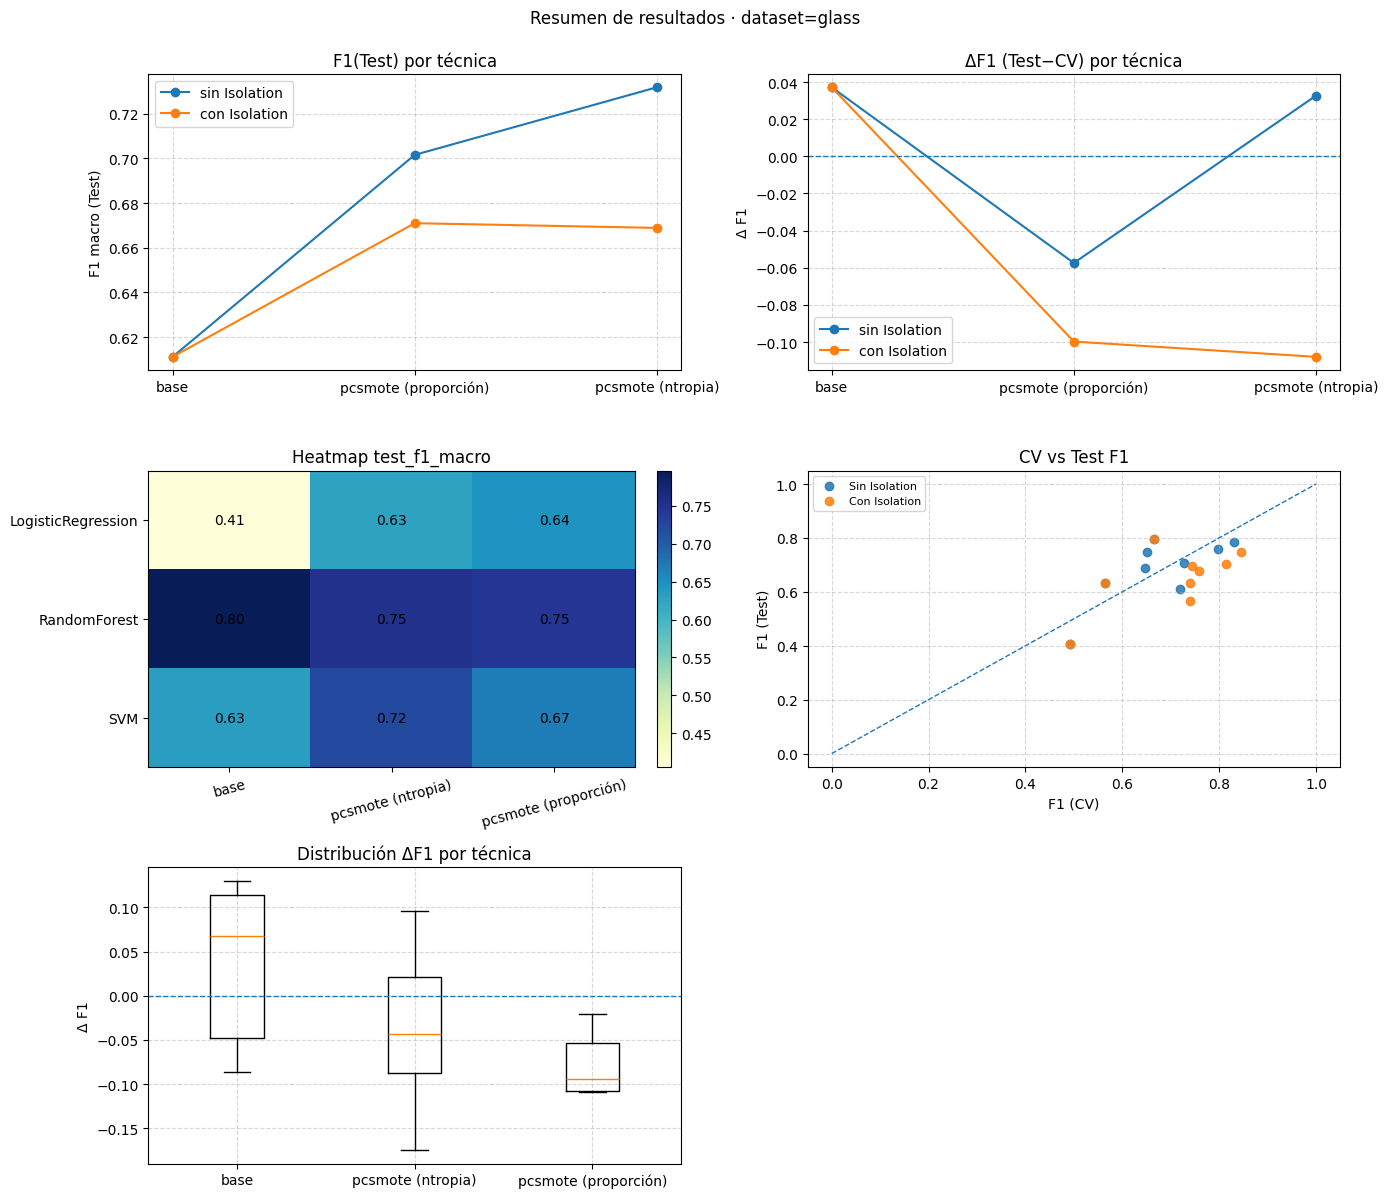

In [4]:
from graficador_resultados import GraficadorResultados

graficador = GraficadorResultados(sin_iso, con_iso)
graficador.preparar_datos()

# Un bloque para 'glass'
graficador.panel_por_dataset(dataset="glass",
                             modelo=None,
                             metrica_heatmap="test_f1_macro",
                             usar_delta_heatmap=False,
                             figsize=(14,12),
                             guardar_path="figs/panel_glass.png")
